In [7]:
from od import OD
from test_data import generate_test
import datetime
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import auc, fps, TimeoutException
import os
import numpy as np
import stopit
import pandas as pd

In [13]:
n = 100
p = 32

gamma = 0.05
p_frac = 0.3
p_quant = 0.3
r = 20
# out_type = 'point'

os.makedirs("./images/", exist_ok=True)

timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)

2021-07-19_14-06-31


In [14]:

def plot_data(timestamp):
    # matrix plots
    pca = PCA(2, svd_solver='full')
    pca_lst = []
    out_lst = []
    plt.figure(figsize=(3*2+1.5,2+1.5))
    for i in range(6):
        fig = plt.subplot(1,6,i+1)
        X, outs = generate_test(n,p,r, p_frac, p_quant,gamma, noise=0.1, ta=i+1)
        plt.imshow(X)
        # plt.title('noise = {}'.format(np.round(i/5, 1)) )
        for out in outs:
            fig.text(-5,out+2, 'o-', color='r')
        plt.title('D{}'.format(i+1))
        #pca plots
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca.fit_transform(X)
        pca_lst.append(X_pca)
        out_lst.append(outs)
    fname = '{}_data_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp,n,p,r,gamma,p_frac,p_quant)
    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.figure(figsize=(3*3+2,2*2.5+1))
    for i in range(6):
        fig = plt.subplot(2,3,i+1)
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca_lst[i]
        outs = out_lst[i]
        plt.plot(X_pca[:,0], X_pca[:,1], 'b.')
        plt.title('D{}'.format(i+1))

        for out in outs:
            # print(out)
            plt.plot(X_pca[out, 0], X_pca[out,1], 'rx')
    fname = '{}_data_pca_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp, n,p,r,gamma,p_frac,p_quant)

    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
def plot_data_noise(timestamp):
    # matrix plots
    pca = PCA(2, svd_solver='full')
    pca_lst = []
    out_lst = []
    plt.figure(figsize=(3*2+1.5,2+1.5))
    for i in range(6):
        fig = plt.subplot(1,6,i+1)
        X, outs = generate_test(n,p,r, p_frac, p_quant,gamma, noise=i/5, ta=1)
        plt.imshow(X)
        plt.title('noise\n={}'.format(round(i/5, 1)) )
        for out in outs:
            fig.text(-5,out+1, 'o-', color='r')

        #pca plots
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca.fit_transform(X)
        pca_lst.append(X_pca)
        out_lst.append(outs)
    fname = '{}_data_noise_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp,n,p,r,gamma,p_frac,p_quant)
    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.figure(figsize=(3*3+2,2*2.5+1))
    for i in range(6):
        fig = plt.subplot(2,3,i+1)
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca_lst[i]
        outs = out_lst[i]
        plt.plot(X_pca[:,0], X_pca[:,1], 'b.')
        plt.title('noise {}'.format(i))
        for out in outs:
            # print(out)
            plt.plot(X_pca[out, 0], X_pca[out,1], 'rx')
    fname = '{}_data_noise_pca_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp, n,p,r,gamma,p_frac,p_quant)

    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0.1)
    plt.show()

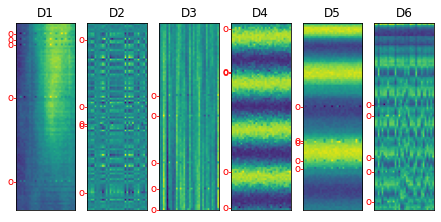

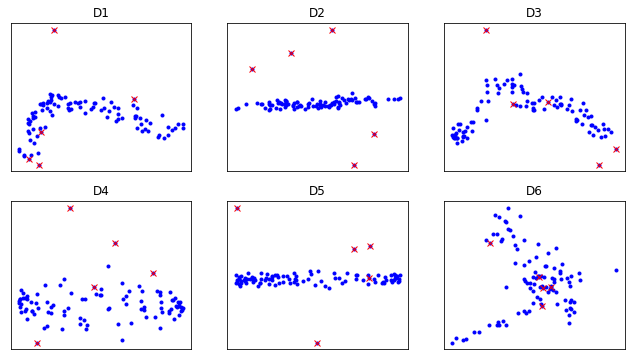

In [15]:
plot_data(timestamp)

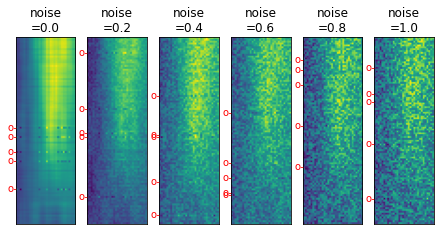

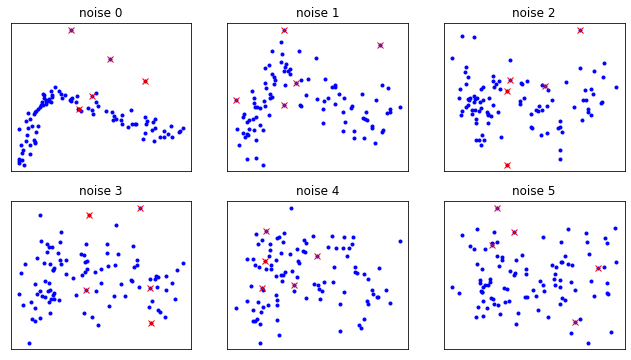

In [16]:
plot_data_noise(timestamp)